In [1]:
!pip install -U sentence-transformers datasets transformers accelerate torch scikit-learn pandas tqdm beautifulsoup4 requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 848.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 151.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [18]:
# 01_build_dataset.py  (FAST + RETRY + MORE PASSAGES + CSV)
import os
import re
import csv
import random
import time
from typing import List

import requests
from tqdm import tqdm

random.seed(42)

DATA_DIR = "data"
RAW_DIR = os.path.join(DATA_DIR, "raw")
os.makedirs(RAW_DIR, exist_ok=True)

USER_AGENT = "collective-learning-project/1.0 (edu)"
SESSION = requests.Session()
SESSION.headers.update({"User-Agent": USER_AGENT})

WIKI_META_API = "https://en.wikipedia.org/w/api.php"

# ===== KATEGORİLER (geniş)
CATEGORIES = [
    "Category:Robotics",
    "Category:Artificial_intelligence",
    "Category:Machine_learning",
    "Category:Control_theory",
    "Category:Computer_vision",
    "Category:Natural_language_processing",
    "Category:Reinforcement_learning",
    "Category:Optimization",
    "Category:Signal_processing",
    "Category:Neural_networks",
    "Category:Information_retrieval",
    "Category:Data_science",
    "Category:Algorithms",
    "Category:Statistics",
    "Category:Applied_mathematics",
    "Category:Systems_theory",
]

# ===== SAYI ŞARTINI GARANTİLEMEK İÇİN AYARLAR
TARGET_PASSAGES = 6500
MAX_PAGES_TO_TRY = 900
MIN_PASSAGES_PER_PAGE = 2

# passage split ayarları (daha çok passage)
TARGET_WORDS = 120
MIN_WORDS = 50

def get_category_members(category: str, limit: int = 500) -> List[str]:
    titles = []
    cont = None
    while True:
        params = {
            "action": "query",
            "format": "json",
            "list": "categorymembers",
            "cmtitle": category,
            "cmlimit": 200,
            "cmtype": "page",
        }
        if cont:
            params["cmcontinue"] = cont

        r = SESSION.get(WIKI_META_API, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()

        members = data.get("query", {}).get("categorymembers", [])
        for m in members:
            titles.append(m["title"])
            if len(titles) >= limit:
                return titles

        cont = data.get("continue", {}).get("cmcontinue")
        if not cont:
            break
    return titles

def fetch_page_text(title: str) -> str:
    params = {
        "action": "query",
        "format": "json",
        "prop": "extracts",
        "explaintext": 1,
        "exsectionformat": "plain",
        "redirects": 1,
        "titles": title,
    }

    # retry/backoff: 429 / timeout / geçici ağ hataları
    for attempt in range(6):
        try:
            r = SESSION.get(WIKI_META_API, params=params, timeout=30)

            if r.status_code == 429:
                time.sleep(1.5 * (attempt + 1))
                continue

            r.raise_for_status()
            data = r.json()
            pages = data.get("query", {}).get("pages", {})
            page = next(iter(pages.values()))
            return page.get("extract", "") or ""

        except Exception:
            time.sleep(0.6 * (attempt + 1))

    return ""

def split_into_passages(text: str, target_words: int = TARGET_WORDS, min_words: int = MIN_WORDS) -> List[str]:
    sentences = re.split(r"(?<=[.!?])\s+", text)
    passages, cur, count = [], [], 0

    for s in sentences:
        w = len(s.split())
        if w < 3:
            continue
        cur.append(s)
        count += w
        if count >= target_words:
            p = " ".join(cur).strip()
            if len(p.split()) >= min_words:
                passages.append(p)
            cur, count = [], 0

    tail = " ".join(cur).strip()
    if len(tail.split()) >= min_words:
        passages.append(tail)

    return passages

def main():
    print("▶ Wikipedia kategorilerinden sayfa başlıkları toplanıyor...")

    all_titles = []
    for cat in CATEGORIES:
        try:
            all_titles.extend(get_category_members(cat, limit=500))
        except Exception:
            continue

    titles = list(set(all_titles))
    random.shuffle(titles)

    print(f"▶ Toplam {len(titles)} benzersiz sayfa bulundu.")

    raw_pages_csv = os.path.join(RAW_DIR, "raw_pages.csv")
    passages_csv = os.path.join(DATA_DIR, "passages.csv")

    raw_rows = []
    passage_rows = []

    passage_count = 0
    pages_tried = 0
    errors = 0

    for title in tqdm(titles, desc="Sayfalar indiriliyor"):
        if passage_count >= TARGET_PASSAGES:
            break
        if pages_tried >= MAX_PAGES_TO_TRY:
            break

        try:
            text = fetch_page_text(title)
            pages_tried += 1

            # daha gevşek filtre: kısa sayfaları da al
            if not text or len(text.split()) < 120:
                continue

            passages = split_into_passages(text)

            if len(passages) >= MIN_PASSAGES_PER_PAGE:
                raw_rows.append({"title": title, "text": text, "num_passages": len(passages)})

                for p in passages:
                    passage_rows.append({"title": title, "passage": p})

                passage_count += len(passages)

        except Exception:
            errors += 1
            continue

    print("▶ CSV dosyaları yazılıyor...")

    with open(raw_pages_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["title", "text", "num_passages"])
        writer.writeheader()
        writer.writerows(raw_rows)

    with open(passages_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["title", "passage"])
        writer.writeheader()
        writer.writerows(passage_rows)

    print("✅ Tamamlandı!")
    print(f"Denendi: {pages_tried} sayfa")
    print(f"Raw pages: {len(raw_rows)} sayfa → {raw_pages_csv}")
    print(f"Passages : {len(passage_rows)} passage → {passages_csv}")
    print(f"Hata sayısı: {errors}")

if __name__ == "__main__":
    main()


▶ Wikipedia kategorilerinden sayfa başlıkları toplanıyor...
▶ Toplam 1835 benzersiz sayfa bulundu.


Sayfalar indiriliyor:  37%|███▋      | 682/1835 [06:25<10:52,  1.77it/s]


▶ CSV dosyaları yazılıyor...
✅ Tamamlandı!
Denendi: 682 sayfa
Raw pages: 604 sayfa → data/raw/raw_pages.csv
Passages : 6501 passage → data/passages.csv
Hata sayısı: 0


In [21]:
!pip -q install -U huggingface_hub transformers sentencepiece
from huggingface_hub import login
login()

## İngilizce --> Türkçe Çeviri

In [25]:
import pandas as pd
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

IN_PATH = "data/passages.csv"         # EN passages
OUT_PATH = "data/passages_tr.csv"     # TR passages (raw)

# ✅ Doğru çalışan model:
MODEL_NAME = "Helsinki-NLP/opus-mt-tc-big-en-tr"

BATCH_SIZE = 8
MAX_NEW_TOKENS = 220
TARGET_TRANSLATE = 4000   # yeterli (2000/500 için)

def main():
    df = pd.read_csv(IN_PATH).dropna(subset=["passage"]).copy()
    df = df.sample(n=min(TARGET_TRANSLATE, len(df)), random_state=42).reset_index(drop=True)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    tok = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)

    passages = df["passage"].astype(str).tolist()
    tr_out = []

    for i in tqdm(range(0, len(passages), BATCH_SIZE), desc="Translating EN->TR"):
        batch = passages[i:i+BATCH_SIZE]
        inputs = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            gen = model.generate(**inputs, num_beams=4, max_new_tokens=MAX_NEW_TOKENS)
        tr_out.extend(tok.batch_decode(gen, skip_special_tokens=True))

    df["passage"] = tr_out
    df.to_csv(OUT_PATH, index=False)
    print("Saved:", OUT_PATH, "rows:", len(df))

if __name__ == "__main__":
    main()


Device: cuda


tokenizer_config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/833k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/470M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Translating EN->TR: 100%|██████████| 500/500 [36:59<00:00,  4.44s/it]

Saved: data/passages_tr.csv rows: 4000


In [26]:
import re
import pandas as pd

IN_PATH = "data/passages_tr.csv"
OUT_PATH = "data/passages_tr_clean.csv"

MIN_WORDS = 25
MAX_WORDS = 260

def normalize(t: str) -> str:
    t = str(t).replace("\u200b", " ")
    t = re.sub(r"\s+", " ", t).strip()
    return t

def too_symbolic(t: str) -> bool:
    sym = sum(1 for ch in t if ch in "{}[]()=<>±×÷∫∑√_^")
    return (sym / max(1, len(t))) > 0.03

def main():
    df = pd.read_csv(IN_PATH).dropna(subset=["passage"]).copy()
    df["passage"] = df["passage"].apply(normalize)
    df["n_words"] = df["passage"].str.split().str.len()

    before = len(df)
    df = df[(df["n_words"] >= MIN_WORDS) & (df["n_words"] <= MAX_WORDS)].copy()
    df = df[~df["passage"].apply(too_symbolic)].copy()
    df = df.drop_duplicates(subset=["passage"]).copy()
    after = len(df)

    df.to_csv(OUT_PATH, index=False)
    print("Saved:", OUT_PATH)
    print("Before:", before, "After:", after)
    print("Unique titles:", df["title"].nunique())

if __name__ == "__main__":
    main()


Saved: data/passages_tr_clean.csv
Before: 3994 After: 3468
Unique titles: 584


In [27]:
import pandas as pd

IN_PATH = "data/passages_tr_clean.csv"

def main():
    df = pd.read_csv(IN_PATH)
    df["n_words"] = df["passage"].astype(str).str.split().str.len()

    print("Rows:", len(df))
    print("Unique titles:", df["title"].nunique())
    print("\nWord stats:")
    print(df["n_words"].describe(percentiles=[0.1,0.25,0.5,0.75,0.9,0.95,0.99]))

    print("\n--- 10 random passages ---")
    print(df.sample(10, random_state=42)[["title","n_words","passage"]].to_string(index=False))

if __name__ == "__main__":
    main()


Rows: 3468
Unique titles: 584

Word stats:
count    3468.000000
mean       59.281719
std        12.140602
min        25.000000
10%        46.000000
25%        53.000000
50%        60.000000
75%        65.000000
90%        70.000000
95%        74.000000
99%        93.660000
max       208.000000
Name: n_words, dtype: float64

--- 10 random passages ---
                                                title  n_words                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   passag

In [29]:
# 12_make_tr_triples_csv.py
import re
import random
import pandas as pd

random.seed(42)

IN_PATH = "data/passages_tr_clean.csv"
OUT_TRAIN = "data/train_tr.csv"
OUT_TEST  = "data/test_tr.csv"

N_TRAIN = 2200
N_TEST  = 600

# --------------------------------------------------
# Yardımcı fonksiyonlar
# --------------------------------------------------

def normalize(text: str) -> str:
    text = str(text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def bad_math_artifact(text: str) -> bool:
    """
    LaTeX / displaystyle artığı içeren bozuk cümleleri eler
    """
    bad_tokens = [
        "displaystyle", "\\", "{", "}", "^",
        "∑", "∫", "σ", "erf", "_", "="
    ]
    hits = sum(1 for t in bad_tokens if t in text)
    return hits >= 2

def make_query_tr(passage: str) -> str:
    first_sentence = re.split(r"(?<=[.!?])\s+", passage)[0]
    if len(first_sentence.split()) < 5:
        first_sentence = " ".join(passage.split()[:16])
    return f"Açıkla: {first_sentence.strip()}"

def token_set(text: str, max_tokens: int = 80) -> set:
    return set(text.lower().split()[:max_tokens])

def choose_negative(pos_text: str, pool: list, max_tries: int = 40) -> str:
    pos_tokens = token_set(pos_text)
    for _ in range(max_tries):
        neg = random.choice(pool)
        overlap = len(pos_tokens & token_set(neg)) / max(1, len(pos_tokens))
        if overlap < 0.15:
            return neg
    return random.choice(pool)

# --------------------------------------------------
# Triple üretimi
# --------------------------------------------------

def build_triples(passages: list, n: int):
    indices = list(range(len(passages)))
    random.shuffle(indices)
    rows = []

    for idx in indices:
        if len(rows) >= n:
            break
        pos = passages[idx]
        neg = choose_negative(pos, passages)
        rows.append({
            "query": make_query_tr(pos),
            "positive": pos,
            "negative": neg
        })

    return rows

def main():
    df = pd.read_csv(IN_PATH).dropna(subset=["passage"]).copy()
    df["passage"] = df["passage"].apply(normalize)

    # 🔥 BOZUK MATEMATİK PASAJLARINI ELE
    before_math = len(df)
    df = df[~df["passage"].apply(bad_math_artifact)].copy()
    after_math = len(df)

    df = df.drop_duplicates(subset=["passage"]).copy()

    print(f"Filtered math artifacts: {before_math} → {after_math}")

    # 🔒 data leakage önlemek için title bazlı split
    titles = df["title"].unique().tolist()
    random.shuffle(titles)
    split = int(len(titles) * 0.8)

    train_titles = set(titles[:split])
    test_titles  = set(titles[split:])

    train_passages = df[df["title"].isin(train_titles)]["passage"].tolist()
    test_passages  = df[df["title"].isin(test_titles)]["passage"].tolist()

    print("Train passages:", len(train_passages))
    print("Test passages :", len(test_passages))

    assert len(train_passages) >= N_TRAIN, "❌ Train passage yetersiz"
    assert len(test_passages)  >= N_TEST,  "❌ Test passage yetersiz"

    train_rows = build_triples(train_passages, N_TRAIN)
    test_rows  = build_triples(test_passages,  N_TEST)

    pd.DataFrame(train_rows).to_csv(OUT_TRAIN, index=False)
    pd.DataFrame(test_rows).to_csv(OUT_TEST,  index=False)

    print("✅ Saved:", OUT_TRAIN, f"({len(train_rows)} rows)")
    print("✅ Saved:", OUT_TEST,  f"({len(test_rows)} rows)")

    print("\n--- Sample triples ---")
    for r in train_rows[:2]:
        print("Q :", r["query"])
        print("POS:", r["positive"][:140], "...")
        print("NEG:", r["negative"][:140], "...")
        print("-"*60)

if __name__ == "__main__":
    main()


Filtered math artifacts: 3468 → 3244
Train passages: 2522
Test passages : 722
✅ Saved: data/train_tr.csv (2200 rows)
✅ Saved: data/test_tr.csv (600 rows)

--- Sample triples ---
Q : Açıkla: İlk algoritma ve performans metriklerinden başlayarak AlphaEvolve, yeni adaylar oluşturmak için bir LLM kullanarak mevcut algoritmaları tekrar tekrar değiştirir veya birleştirir, daha ileri iterasyonlar için en umut verici adayları seçer.
POS: İlk algoritma ve performans metriklerinden başlayarak AlphaEvolve, yeni adaylar oluşturmak için bir LLM kullanarak mevcut algoritmaları tekr ...
NEG: Altta yatan teknolojilerin değerlendirilmesi Genellikle, belirli bir şekilde çalışan belirli bir sınıflandırıcıyı değil, altta yatan bir tek ...
------------------------------------------------------------
Q : Açıkla: TP model dönüşümü, burada daha fazla bilginin bulunabileceği "HOSVD TP fonksiyonlarının kanonik formu" tanımını motive etti.
POS: TP model dönüşümü, burada daha fazla bilginin bulunabileceği "HOSVD 

In [1]:
import os, gc, torch
import random
import pandas as pd

gc.collect()
torch.cuda.empty_cache()
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

In [4]:
import os
import random
import pandas as pd

from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses

random.seed(42)

TRAIN_CSV = "data/train_tr.csv"
OUT_MODEL_DIR = "outputs_tr"
OUT_SUBSET_DIR = "data/subsets"

os.makedirs(OUT_MODEL_DIR, exist_ok=True)
os.makedirs(OUT_SUBSET_DIR, exist_ok=True)

MODEL_NAME = "ytu-ce-cosmos/turkish-e5-large"

EPOCHS = 1
BATCH_SIZE = 4      # 🔻 küçük batch -> OOM çözümü
LR = 2e-5
SUBSET_SIZE = 2000

def df_to_examples(df: pd.DataFrame):
    return [InputExample(texts=[q, p]) for q, p in zip(df["query"], df["positive"])]

def train_model(model_idx: int, subset_df: pd.DataFrame):
    subset_path = os.path.join(OUT_SUBSET_DIR, f"train_submodel_{model_idx}.csv")
    subset_df.to_csv(subset_path, index=False)
    print(f"✅ Saved subset: {subset_path} (rows={len(subset_df)})")

    model = SentenceTransformer(MODEL_NAME, device="cuda")
    train_loader = DataLoader(
        df_to_examples(subset_df),
        shuffle=True,
        batch_size=BATCH_SIZE,
        drop_last=True
    )
    train_loss = losses.MultipleNegativesRankingLoss(model=model)

    out_path = os.path.join(OUT_MODEL_DIR, f"model_{model_idx}")
    warmup_steps = int(len(train_loader) * EPOCHS * 0.1)

    model.fit(
        train_objectives=[(train_loader, train_loss)],
        epochs=EPOCHS,
        warmup_steps=warmup_steps,
        optimizer_params={"lr": LR},
        output_path=out_path,
        show_progress_bar=True,
        use_amp=True,  # ✅ fp16 -> ciddi RAM düşürür
    )

    print(f"✅ Saved model: {out_path}")

def main():
    df = pd.read_csv(TRAIN_CSV)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    m1 = df.iloc[:SUBSET_SIZE].copy()
    m2 = df.iloc[200:200+SUBSET_SIZE].copy()
    m3 = df.sample(n=SUBSET_SIZE, random_state=7).copy()

    train_model(1, m1)
    train_model(2, m2)
    train_model(3, m3)

if __name__ == "__main__":
    main()


✅ Saved subset: data/subsets/train_submodel_1.csv (rows=2000)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.000500


✅ Saved model: outputs_tr/model_1
✅ Saved subset: data/subsets/train_submodel_2.csv (rows=2000)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.000500


✅ Saved model: outputs_tr/model_2
✅ Saved subset: data/subsets/train_submodel_3.csv (rows=2000)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.000400


✅ Saved model: outputs_tr/model_3


In [2]:
import os
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

TEST_CSV = "data/test_tr.csv"
MODEL_DIR = "outputs_tr"
RESULT_DIR = "data/results"
os.makedirs(RESULT_DIR, exist_ok=True)

# --------------------------------------------------
# Metrik fonksiyonları
# --------------------------------------------------

def compute_metrics(scores: np.ndarray, gt: np.ndarray, k_list=(5, 10)):
    ranks = np.argsort(-scores, axis=1)

    out = {}

    # Recall@K
    for k in k_list:
        out[f"Recall@{k}"] = float(
            np.mean([gt[i] in ranks[i, :k] for i in range(len(gt))])
        )

    # MRR & Mean Rank
    rr = 0.0
    mr = 0.0
    for i in range(len(gt)):
        pos_rank = int(np.where(ranks[i] == gt[i])[0][0]) + 1
        rr += 1.0 / pos_rank
        mr += pos_rank

    out["MRR"] = rr / len(gt)
    out["MR"] = mr / len(gt)

    # nDCG@K (binary relevance)
    for k in k_list:
        ndcg = 0.0
        for i in range(len(gt)):
            if gt[i] in ranks[i, :k]:
                pos_rank = int(np.where(ranks[i] == gt[i])[0][0]) + 1
                ndcg += 1.0 / np.log2(pos_rank + 1)
        out[f"nDCG@{k}"] = ndcg / len(gt)

    return out

# --------------------------------------------------
# Tek model değerlendirme
# --------------------------------------------------

def eval_model(model: SentenceTransformer, df: pd.DataFrame):
    queries = df["query"].tolist()
    positives = df["positive"].tolist()
    negatives = df["negative"].tolist()

    candidates = positives + negatives
    gt = np.arange(len(df))

    q_emb = model.encode(
        queries,
        batch_size=64,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=True
    )
    c_emb = model.encode(
        candidates,
        batch_size=64,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=True
    )

    scores = q_emb @ c_emb.T
    return compute_metrics(scores, gt)

# --------------------------------------------------
# Ensemble (embedding average)
# --------------------------------------------------

def eval_ensemble(models, df: pd.DataFrame):
    queries = df["query"].tolist()
    positives = df["positive"].tolist()
    negatives = df["negative"].tolist()

    candidates = positives + negatives
    gt = np.arange(len(df))

    q_list, c_list = [], []

    for m in models:
        q_list.append(
            m.encode(queries, batch_size=64, convert_to_numpy=True,
                     normalize_embeddings=True, show_progress_bar=False)
        )
        c_list.append(
            m.encode(candidates, batch_size=64, convert_to_numpy=True,
                     normalize_embeddings=True, show_progress_bar=False)
        )

    q_avg = np.mean(np.stack(q_list), axis=0)
    c_avg = np.mean(np.stack(c_list), axis=0)

    # normalize again
    q_avg = q_avg / (np.linalg.norm(q_avg, axis=1, keepdims=True) + 1e-12)
    c_avg = c_avg / (np.linalg.norm(c_avg, axis=1, keepdims=True) + 1e-12)

    scores = q_avg @ c_avg.T
    return compute_metrics(scores, gt)

# --------------------------------------------------
# Main
# --------------------------------------------------

def main():
    df = pd.read_csv(TEST_CSV)

    m1 = SentenceTransformer(os.path.join(MODEL_DIR, "model_1"))
    m2 = SentenceTransformer(os.path.join(MODEL_DIR, "model_2"))
    m3 = SentenceTransformer(os.path.join(MODEL_DIR, "model_3"))
    models = [m1, m2, m3]

    rows = []

    for i, m in enumerate(models, start=1):
        met = eval_model(m, df)
        met["model"] = f"model_{i}"
        rows.append(met)

    ens = eval_ensemble(models, df)
    ens["model"] = "ensemble_mean"
    rows.append(ens)

    out_df = pd.DataFrame(rows)[[
        "model",
        "Recall@5", "Recall@10",
        "MRR", "MR",
        "nDCG@5", "nDCG@10"
    ]]

    out_path = os.path.join(RESULT_DIR, "metrics_tr_plus.csv")
    out_df.to_csv(out_path, index=False)

    print("✅ Saved metrics:", out_path)
    print(out_df)

if __name__ == "__main__":
    main()


The tokenizer you are loading from 'outputs_tr/model_1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The tokenizer you are loading from 'outputs_tr/model_2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The tokenizer you are loading from 'outputs_tr/model_3' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix t

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

✅ Saved metrics: data/results/metrics_tr_plus.csv
           model  Recall@5  Recall@10       MRR        MR    nDCG@5   nDCG@10
0        model_1       1.0        1.0  0.821500  1.425000  0.867469  0.867469
1        model_2       1.0        1.0  0.819361  1.431667  0.865862  0.865862
2        model_3       1.0        1.0  0.828639  1.408333  0.872794  0.872794
3  ensemble_mean       1.0        1.0  0.833306  1.393333  0.876289  0.876289


In [2]:
import os
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

TEST_CSV = "data/test_tr.csv"
MODEL_DIR = "outputs_tr"

OUT_DIR = "data/results"
os.makedirs(OUT_DIR, exist_ok=True)

TOPK = 10          # ekranda gösterilecek ilk K
N_SAMPLES = 8      # kaç query inceleyeceğiz (istersen artır)

def encode(model, texts):
    return model.encode(
        texts,
        batch_size=64,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=False
    )

def rank_for_one(model, q_text, candidates, pos_index=0):
    q = encode(model, [q_text])               # (1, d)
    c = encode(model, candidates)             # (n, d)
    scores = (q @ c.T).reshape(-1)            # (n,)
    order = np.argsort(-scores)               # desc
    pos_rank = int(np.where(order == pos_index)[0][0]) + 1
    return scores, order, pos_rank

def rank_for_one_ensemble(models, q_text, candidates, pos_index=0):
    q_embs = [encode(m, [q_text])[0] for m in models]          # list of (d,)
    c_embs = [encode(m, candidates) for m in models]           # list of (n,d)

    q_avg = np.mean(np.stack(q_embs), axis=0)                  # (d,)
    c_avg = np.mean(np.stack(c_embs), axis=0)                  # (n,d)

    # normalize
    q_avg = q_avg / (np.linalg.norm(q_avg) + 1e-12)
    c_avg = c_avg / (np.linalg.norm(c_avg, axis=1, keepdims=True) + 1e-12)

    scores = c_avg @ q_avg                                     # (n,)
    order = np.argsort(-scores)
    pos_rank = int(np.where(order == pos_index)[0][0]) + 1
    return scores, order, pos_rank

def preview(text, n=1000):
    t = " ".join(str(text).split())
    return t[:n] + ("..." if len(t) > n else "")

def main():
    df = pd.read_csv(TEST_CSV)

    # model yükle
    m1 = SentenceTransformer(os.path.join(MODEL_DIR, "model_1"))
    m2 = SentenceTransformer(os.path.join(MODEL_DIR, "model_2"))
    m3 = SentenceTransformer(os.path.join(MODEL_DIR, "model_3"))
    models = {"model_1": m1, "model_2": m2, "model_3": m3}

    # örnek seç
    sample_df = df.sample(n=min(N_SAMPLES, len(df)), random_state=42).reset_index(drop=True)

    rows = []  # CSV için örnek çıktı satırları

    for i, row in sample_df.iterrows():
        q = row["query"]
        pos = row["positive"]
        neg = row["negative"]

        # Şu anki test setin 1 positive + 1 negative içeriyor.
        # (İstersen ileride daha çok negative eklenebilir.)
        candidates = [pos, neg]
        pos_index = 0  # candidates[0] positive

        print("\n" + "="*90)
        print(f"SAMPLE {i+1}")
        print("QUERY:", preview(q, 220))
        print("POS  :", preview(pos, 220))
        print("NEG  :", preview(neg, 220))

        for name, model in models.items():
            scores, order, pos_rank = rank_for_one(model, q, candidates, pos_index=pos_index)

            print(f"\n[{name}] POS RANK = {pos_rank} | pos_score={scores[pos_index]:.4f} | neg_score={scores[1]:.4f}")
            print(f"Top-{min(TOPK, len(candidates))} sıralama:")
            for r, idx in enumerate(order[:min(TOPK, len(candidates))], start=1):
                label = "POS" if idx == pos_index else "NEG"
                print(f"  #{r} {label}  score={scores[idx]:.4f}  text={preview(candidates[idx], 120)}")

            rows.append({
                "sample_id": i+1,
                "model": name,
                "pos_rank": pos_rank,
                "pos_score": float(scores[pos_index]),
                "neg_score": float(scores[1]),
                "query": q,
                "pos_preview": preview(pos, 220),
                "neg_preview": preview(neg, 220),
            })

        # ensemble
        scores_e, order_e, pos_rank_e = rank_for_one_ensemble([m1, m2, m3], q, candidates, pos_index=pos_index)
        print(f"\n[ensemble_mean] POS RANK = {pos_rank_e} | pos_score={scores_e[pos_index]:.4f} | neg_score={scores_e[1]:.4f}")
        print(f"Top-{min(TOPK, len(candidates))} sıralama:")
        for r, idx in enumerate(order_e[:min(TOPK, len(candidates))], start=1):
            label = "POS" if idx == pos_index else "NEG"
            print(f"  #{r} {label}  score={scores_e[idx]:.4f}  text={preview(candidates[idx], 120)}")

        rows.append({
            "sample_id": i+1,
            "model": "ensemble_mean",
            "pos_rank": pos_rank_e,
            "pos_score": float(scores_e[pos_index]),
            "neg_score": float(scores_e[1]),
            "query": q,
            "pos_preview": preview(pos, 220),
            "neg_preview": preview(neg, 220),
        })

    out_path = os.path.join(OUT_DIR, "qualitative_examples_rankings.csv")
    pd.DataFrame(rows).to_csv(out_path, index=False)
    print("\n✅ Kaydedildi:", out_path)
    print("CSV içinde her sample için her modelin pos_rank / skorları var.")

if __name__ == "__main__":
    main()


The tokenizer you are loading from 'outputs_tr/model_1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The tokenizer you are loading from 'outputs_tr/model_2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The tokenizer you are loading from 'outputs_tr/model_3' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix t


SAMPLE 1
QUERY: Açıkla: Bu tekniklere bir giriş, Skolnik tarafından düzenlenen Radar El Kitabı'nın (3.
POS  : Bu tekniklere bir giriş, Skolnik tarafından düzenlenen Radar El Kitabı'nın (3. baskı) bir bölümünde verilmiştir. Darbe sıkıştırması ile ilgili çoğu araştırmanın temel amacı, düşük sidelobe seviyeleri, Doppler frekans kay...
NEG  : Bu N arsaları bir topluluk olarak bilinir. Şimdi tüm bu arsalarda belirli bir zaman dilimini alın ve voltajın ortalama değerini bulun. Bu size tüm arsalar için topluluk ortalamasını verir. Eğer topluluk ortalaması ve zam...

[model_1] POS RANK = 1 | pos_score=0.8603 | neg_score=0.0760
Top-2 sıralama:
  #1 POS  score=0.8603  text=Bu tekniklere bir giriş, Skolnik tarafından düzenlenen Radar El Kitabı'nın (3. baskı) bir bölümünde verilmiştir. Darbe s...
  #2 NEG  score=0.0760  text=Bu N arsaları bir topluluk olarak bilinir. Şimdi tüm bu arsalarda belirli bir zaman dilimini alın ve voltajın ortalama d...

[model_2] POS RANK = 1 | pos_score=0.8226 | neg_s

✅ Saved table CSV: data/results/ieee_metrics_table.csv
           model     MRR     MR  nDCG@10  Recall@10
0        model_1  0.8215  1.425   0.8675        1.0
1        model_2  0.8194  1.432   0.8659        1.0
2        model_3  0.8286  1.408   0.8728        1.0
3  ensemble_mean  0.8333  1.393   0.8763        1.0
✅ Saved LaTeX table: data/results/ieee_metrics_table.tex


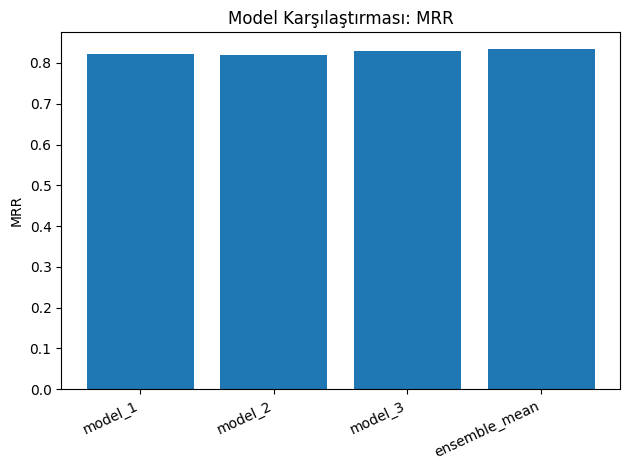

✅ Saved: data/results/plot_mrr.png


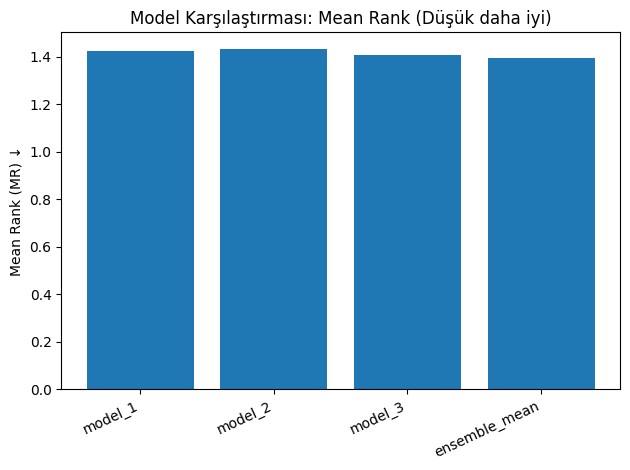

✅ Saved: data/results/plot_mean_rank.png


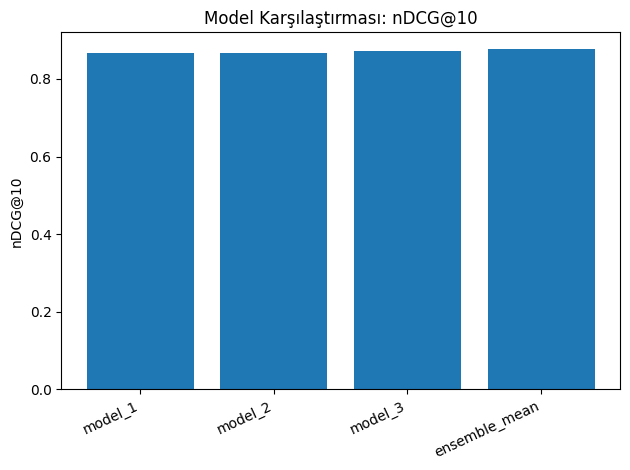

✅ Saved: data/results/plot_ndcg10.png
✅ Saved summary: data/results/ensemble_gain_summary.csv
                                       0
best_single_model                model_3
best_single_MRR                 0.828639
ensemble_MRR                    0.833306
MRR_gain_abs                    0.004667
best_single_MR                  1.408333
ensemble_MR                     1.393333
MR_gain_abs_(negative_is_good)    -0.015
best_single_nDCG10              0.872794
ensemble_nDCG10                 0.876289
nDCG10_gain_abs                 0.003495


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RESULT_DIR = "data/results"
os.makedirs(RESULT_DIR, exist_ok=True)

METRICS_PATH = f"{RESULT_DIR}/metrics_tr_plus.csv"   # senin ürettiğin dosya
OUT_TABLE_CSV = f"{RESULT_DIR}/ieee_metrics_table.csv"
OUT_TABLE_TEX = f"{RESULT_DIR}/ieee_metrics_table.tex"

df = pd.read_csv(METRICS_PATH)

# 1) Rapor tablosu için format (IEEE'ye uygun: az kolon, yuvarlama)
table_df = df.copy()
for col in ["MRR", "MR", "nDCG@5", "nDCG@10", "Recall@5", "Recall@10"]:
    table_df[col] = table_df[col].astype(float)

table_df = table_df[["model","MRR","MR","nDCG@10","Recall@10"]].copy()
table_df["MRR"] = table_df["MRR"].round(4)
table_df["MR"] = table_df["MR"].round(3)
table_df["nDCG@10"] = table_df["nDCG@10"].round(4)
table_df["Recall@10"] = table_df["Recall@10"].round(3)

# CSV kaydet
table_df.to_csv(OUT_TABLE_CSV, index=False)
print("✅ Saved table CSV:", OUT_TABLE_CSV)
print(table_df)

# 2) LaTeX (IEEE rapora yapıştırmalık)
latex = table_df.to_latex(index=False, escape=False)
with open(OUT_TABLE_TEX, "w", encoding="utf-8") as f:
    f.write(latex)
print("✅ Saved LaTeX table:", OUT_TABLE_TEX)

# 3) Grafikler
# (a) MRR bar chart
plt.figure()
plt.bar(df["model"], df["MRR"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("MRR")
plt.title("Model Karşılaştırması: MRR")
plt.tight_layout()
mrr_png = f"{RESULT_DIR}/plot_mrr.png"
plt.savefig(mrr_png, dpi=200)
plt.show()
print("✅ Saved:", mrr_png)

# (b) Mean Rank (daha düşük daha iyi)
plt.figure()
plt.bar(df["model"], df["MR"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("Mean Rank (MR) ↓")
plt.title("Model Karşılaştırması: Mean Rank (Düşük daha iyi)")
plt.tight_layout()
mr_png = f"{RESULT_DIR}/plot_mean_rank.png"
plt.savefig(mr_png, dpi=200)
plt.show()
print("✅ Saved:", mr_png)

# (c) nDCG@10
plt.figure()
plt.bar(df["model"], df["nDCG@10"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("nDCG@10")
plt.title("Model Karşılaştırması: nDCG@10")
plt.tight_layout()
ndcg_png = f"{RESULT_DIR}/plot_ndcg10.png"
plt.savefig(ndcg_png, dpi=200)
plt.show()
print("✅ Saved:", ndcg_png)

# 4) Ensemble kazancı (tekil en iyi modele göre)
best_single = df[df["model"].str.contains("model_")].sort_values("MRR", ascending=False).iloc[0]
ens = df[df["model"].str.contains("ensemble")].iloc[0]

summary = {
    "best_single_model": best_single["model"],
    "best_single_MRR": float(best_single["MRR"]),
    "ensemble_MRR": float(ens["MRR"]),
    "MRR_gain_abs": float(ens["MRR"] - best_single["MRR"]),
    "best_single_MR": float(best_single["MR"]),
    "ensemble_MR": float(ens["MR"]),
    "MR_gain_abs_(negative_is_good)": float(ens["MR"] - best_single["MR"]),  # negatif çıkarsa iyi
    "best_single_nDCG10": float(best_single["nDCG@10"]),
    "ensemble_nDCG10": float(ens["nDCG@10"]),
    "nDCG10_gain_abs": float(ens["nDCG@10"] - best_single["nDCG@10"]),
}

summary_df = pd.DataFrame([summary])
summary_path = f"{RESULT_DIR}/ensemble_gain_summary.csv"
summary_df.to_csv(summary_path, index=False)
print("✅ Saved summary:", summary_path)
print(summary_df.T)


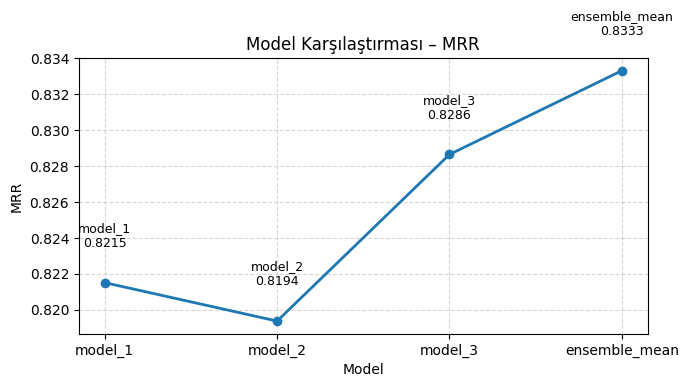

✅ Saved: data/results/line_mrr_models.png


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# veri
df = pd.read_csv("data/results/metrics_tr_plus.csv")

# sıralama (tekiller -> ensemble en sona)
order = ["model_1", "model_2", "model_3", "ensemble_mean"]
df = df.set_index("model").loc[order].reset_index()

plt.figure(figsize=(7,4))
plt.plot(df["model"], df["MRR"], marker="o", linewidth=2)

# nokta etiketleri
for i, row in df.iterrows():
    plt.text(
        i,
        row["MRR"] + 0.002,
        f'{row["model"]}\n{row["MRR"]:.4f}',
        ha="center",
        fontsize=9
    )

plt.ylabel("MRR")
plt.xlabel("Model")
plt.title("Model Karşılaştırması – MRR")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

out = "data/results/line_mrr_models.png"
plt.savefig(out, dpi=200)
plt.show()

print("✅ Saved:", out)

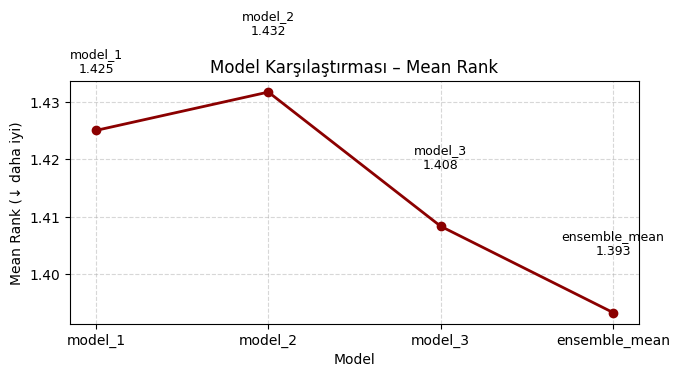

✅ Saved: data/results/line_mean_rank_models.png


In [5]:
plt.figure(figsize=(7,4))
plt.plot(df["model"], df["MR"], marker="o", linewidth=2, color="darkred")

for i, row in df.iterrows():
    plt.text(
        i,
        row["MR"] + 0.01,
        f'{row["model"]}\n{row["MR"]:.3f}',
        ha="center",
        fontsize=9
    )

plt.ylabel("Mean Rank (↓ daha iyi)")
plt.xlabel("Model")
plt.title("Model Karşılaştırması – Mean Rank")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

out = "data/results/line_mean_rank_models.png"
plt.savefig(out, dpi=200)
plt.show()

print("✅ Saved:", out)


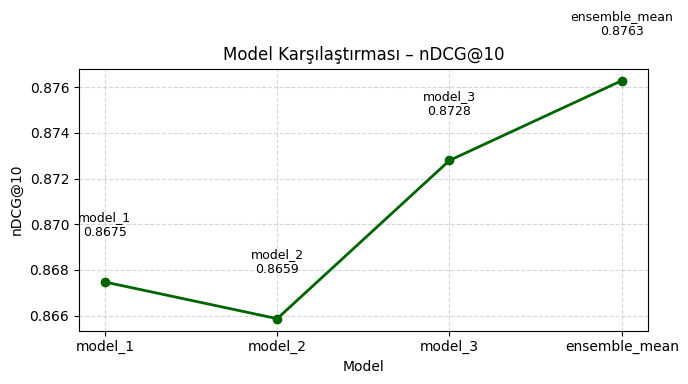

✅ Saved: data/results/line_ndcg10_models.png


In [6]:
plt.figure(figsize=(7,4))
plt.plot(df["model"], df["nDCG@10"], marker="o", linewidth=2, color="darkgreen")

for i, row in df.iterrows():
    plt.text(
        i,
        row["nDCG@10"] + 0.002,
        f'{row["model"]}\n{row["nDCG@10"]:.4f}',
        ha="center",
        fontsize=9
    )

plt.ylabel("nDCG@10")
plt.xlabel("Model")
plt.title("Model Karşılaştırması – nDCG@10")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

out = "data/results/line_ndcg10_models.png"
plt.savefig(out, dpi=200)
plt.show()

print("✅ Saved:", out)


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
!mkdir -p /content/drive/MyDrive/collective_learning_project
!cp -r /content/data /content/drive/MyDrive/collective_learning_project/
!cp -r /content/outputs_tr /content/drive/MyDrive/collective_learning_project/
